# Práctica evaluable - CNNs
## Deep Learning y sus Aplicaciones. Máster en Ingeniería Informática
En esta práctica evaluable sobre redes neuronales convolucionales (CNNs) se tiene como objetivo crear un modelo de Deep Learning para clasificar distintas especies de aves. Se trata del modelo tenga la mejor capacidad de generalizar posible, ya que será evaluado sobre un conjunto de test no conocido. El objetivo es que el modelo tenga la mejor 'accuracy' posible cuando se evalue contra dicho conjunto de test.

## Importación de las librerias necesarias

In [1]:
# Cargamos las librerías habituales
from fastai import *
from fastai.vision.all import *
from sklearn.metrics import *
from pathlib import Path
from jmd_imagescraper.imagecleaner import * #si utilizáis colab tendréis que instalar jmd_imagescraper


import requests
%pip install selenium | grep -v 'already satisfied'
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
import os

import urllib
import time

#para suprimir los warnings a la hora de cargar las imágenes (es un problema de actualización de fastai)
import warnings
warnings.filterwarnings("ignore")

Note: you may need to restart the kernel to use updated packages.


## Creando el dataset

Debido a que no existen datasets públicos de especies de aves con la suficiente variedad en Internet, se van han utilizado técnicas de Image Scraping para descargar imágenes de cada especie de ave disponibles en Internet, y se han organizado en una estructura de carpetas por clases.

En este caso, se ha utilizado la herramienta Selenium para el Web Scraping. 

In [2]:
def searchImages(search, labels):
    if os.path.isdir("dataset"):
        print("Ya existe un dataset")
        return
    
    service = Service(executable_path=r'/usr/bin/chromedriver')
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome(service=service, options=chrome_options)
    #url base de google imágenes sobre la que se realizarán búsquedas
    url = ("https://www.google.com/search?q={s}&tbm=isch&tbs=sur%3Afc&hl=en&ved=0CAIQpwVqFwoTCKCa1c6s4-oCFQAAAAAdAAAAABAC&biw=1251&bih=568")
    #se realiza una búsqueda arbitraria para que aparezca el aviso de Google sobre los datos que recoge y las cookies, y pulsamos el botón
    #que oculta dicho aviso
    driver.get(url.format(s="test"))
    driver.find_elements(By.CLASS_NAME, 'VfPpkd-LgbsSe')[2].click()
    
    nimages = 100

    #se itera sobre todos los animales que vamos a buscar
    for i in range(len(animals)):
        #asignamos a 'animal' la especia de ave a buscar, en inglés, y a 'label' la etiqueta
        #con la que guardaremos la especie de ave, su nombre en español
        animal = animals[i]
        label = labels[i]
        print('Buscando ', label)
        #print(url.format(s=animal))
        driver.get(url.format(s=animal))
        #hacemos scroll tres veces para cargar más imágenes de las que necesitamos, por hubiera algún problema al descargar alguna
        #aproximadamente se cargan 100 por scroll. time.sleep(3) espera 3 segundos, tiempo utilizado para cargar las imágenes.
        driver.execute_script("window.scrollTo(0,document.body.scrollHeight);")
        time.sleep(3)
        driver.execute_script("window.scrollTo(0,document.body.scrollHeight);")
        time.sleep(3)
        driver.execute_script("window.scrollTo(0,document.body.scrollHeight);")
        time.sleep(3)
        #guardamos en imgResults el atributo src de la imagen, que contiene la url de la imagen buscada
        imgResults = driver.find_elements(By.XPATH,"//img[contains(@class,'Q4LuWd')]")
        src = []
        for img in imgResults:
            src.append(img.get_attribute('src')) 
    
        print(len(src), ' images')
        #creamos en el directorio images un subdirectorio con el nombre del animal, en español (label)
        path = "./images/{animal}".format(animal=label)
        os.makedirs(path, exist_ok=True) 
    
        i = 0
        j = -1

        #guardamos nimages (100, en este caso) en el subdirectorio correspondiente a la especie de ave
        while i < nimages:
            j+=1
            try:
                path_to_save = "{path}/{animal}{i}.jpg".format(path=path, animal=label, i=i)
                urllib.request.urlretrieve(str(src[j]),path_to_save)
            except:
                i -= 1
            i += 1
    
        driver.close()
        driver.quit()

#especies de ave a buscar (en ingles) y su etiqueta de clase(en español)
animals = ["cockatoo", "parrot", "black kite", "budgerigar", "stork", "heron", "Gyps fulvus", "Egyptian vulture"]
labels = ["cacatúa", "loro", "milano negro", "periquito", "cigüeña", "garza", "buitre leonado", "alimoche"]

searchImages(animals, labels)

Ya existe un dataset


In [3]:
path = Path().cwd()/"images"
path

Path('/home/jorge/IINF/Master/1C/DEEP/conv/practica/images')

### Limpieza de datos

Al haber obtenido las imágenes para el dataset de forma automática utilizando técnicas de image scrapping, hay imágenes que no se corresponden con la clase y por tanto conviene eliminarlas, ya que son incorrectas. Algunas de las que se han eliminado son dibujos sobre las aves buscadas, imágenes en las que aparecían dos distintas (loro y cacatúa), entre otras.

In [4]:
display_image_cleaner(path)

HTML(value='<h2>No images left to display in this folder.</h2>', layout=Layout(visibility='hidden'))

GridBox(children=(VBox(children=(Image(value=b'', layout="Layout(width='150px')"), Button(description='Delete'…

### Train Val Test Split

Una vez obtenido el dataset, lo dividiremos en conjuntos de entrenamiento, validación y prueba. Para ello, utilizaremos la biblioteca 'splitfolders'. Borraremos la carpeta 'dataset/' si existe, y todas las imágenes del directorio 'images' las guardaremos en el directorio 'dataset', con la partición: 70% para entrenamiento, 15% para validación y 15% para test. De esta manera tendremos la siguiente estructura de directorios. En images habrá una subcarpeta por cada especie de ave, conteniendo todo el dataset, y en cada subdirectorio de dataset, habrá una subcarpeta por cada especie de ave, con las imágenes perteneceientes a esa partición.

-images

-dataset: ----train, -----val, ----test

Se utiliza la semilla 5 para que cada vez que se realice el dataset sea el mismo (obviamente, será el mismo si y solo si las imágenes en /images son las mismas)

In [28]:
%pip install split_folders | grep -v 'already satisfied'
import splitfolders
!rm -rf 'dataset/'
splitfolders.ratio('images', output='dataset', seed=5, ratio=(0.70, 0.15, 0.15))
print('Imagenes divididas en entrenamiento y test')

Note: you may need to restart the kernel to use updated packages.


Copying files: 732 files [00:00, 5392.62 files/s]

Imagenes divididas en entrenamiento y test


In [6]:
datasetTrainPath = Path().cwd()/"dataset/"
datasetTrainPath

Path('/home/jorge/IINF/Master/1C/DEEP/conv/practica/dataset')

## Creación del Modelo

### Carga de los datos de entrenamiento y validación

Cargamos los datos para el entrenamiento, incluyendo también los datos de validación, y aplicamos el Data Augmentation por defecto

In [14]:
data=DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='val'),
    get_y=parent_label,
    item_tfms=[RandomResizedCrop(224, min_scale=0.5)],
    batch_tfms=aug_transforms())

In [15]:
dls=data.dataloaders(datasetTrainPath)

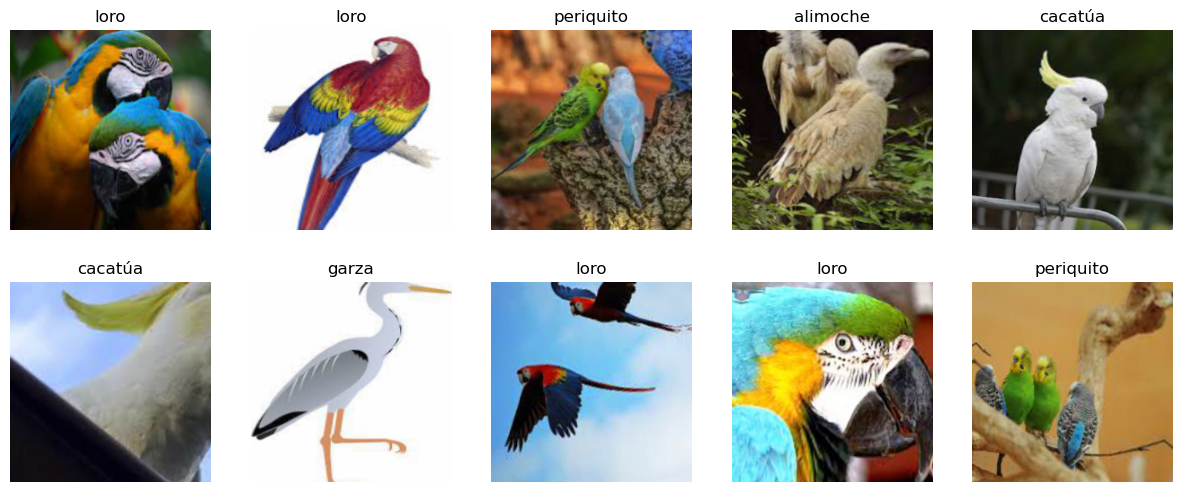

In [16]:
dls.train.show_batch(max_n=10, nrows=2)

### Entrenamiento del modelo

In [20]:
learn = cnn_learner(dls, models.resnext50_32x4d, metrics=accuracy)

cbs_train = [EarlyStoppingCallback(monitor='valid_loss', patience=3), ReduceLROnPlateau(monitor='valid_loss', min_delta=0.10, factor=3.5), SaveModelCallback(monitor='valid_loss', fname='trainmodel', )]

learn.fit_one_cycle(10, cbs=cbs_train)

epoch,train_loss,valid_loss,accuracy,time
0,2.845170,1.167606,0.575472,01:23
1,1.911437,0.277185,0.915094,01:23
2,1.361806,0.350570,0.886792,01:23
3,1.024081,0.334124,0.905660,01:22
4,0.798929,0.344430,0.886792,01:22


Better model found at epoch 0 with valid_loss value: 1.1676058769226074.
Better model found at epoch 1 with valid_loss value: 0.27718546986579895.
Epoch 2: reducing lr to 0.000284118704360637
Epoch 3: reducing lr to 0.00026324607492628097
Epoch 4: reducing lr to 0.00022155734906567835
No improvement since epoch 1: early stopping


### Evaluación tras la primera fase del entrenamiento

Evaluación del modelo sobre el conjunto de test tras la primera fase del entrenamiento (solo ajuste de los pesos de la última capa)

0.27585041522979736 0.9166666865348816


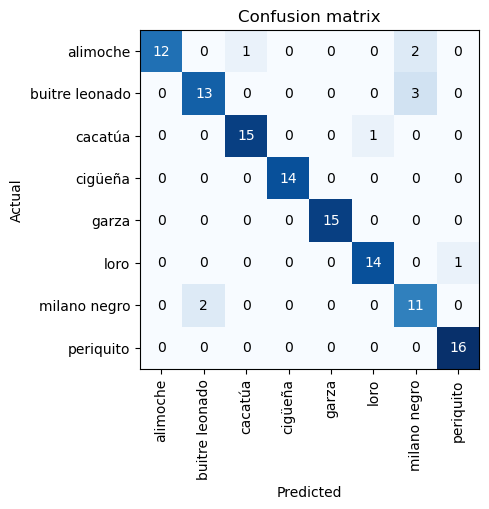

In [26]:
# Cargamos las imágenes del directorio test y realizamos la predicción

learn.load('trainmodel')
datasetTestPath = Path().cwd()/"dataset/test"
test_dl = learn.dls.test_dl(get_image_files(datasetTestPath), with_labels=True)

test_loss, test_accuracy = learn.validate(dl=test_dl)
interpTest = ClassificationInterpretation.from_learner(learn, dl=test_dl)
interpTest.plot_confusion_matrix(figsize=(5,5))
print(test_loss, test_accuracy)

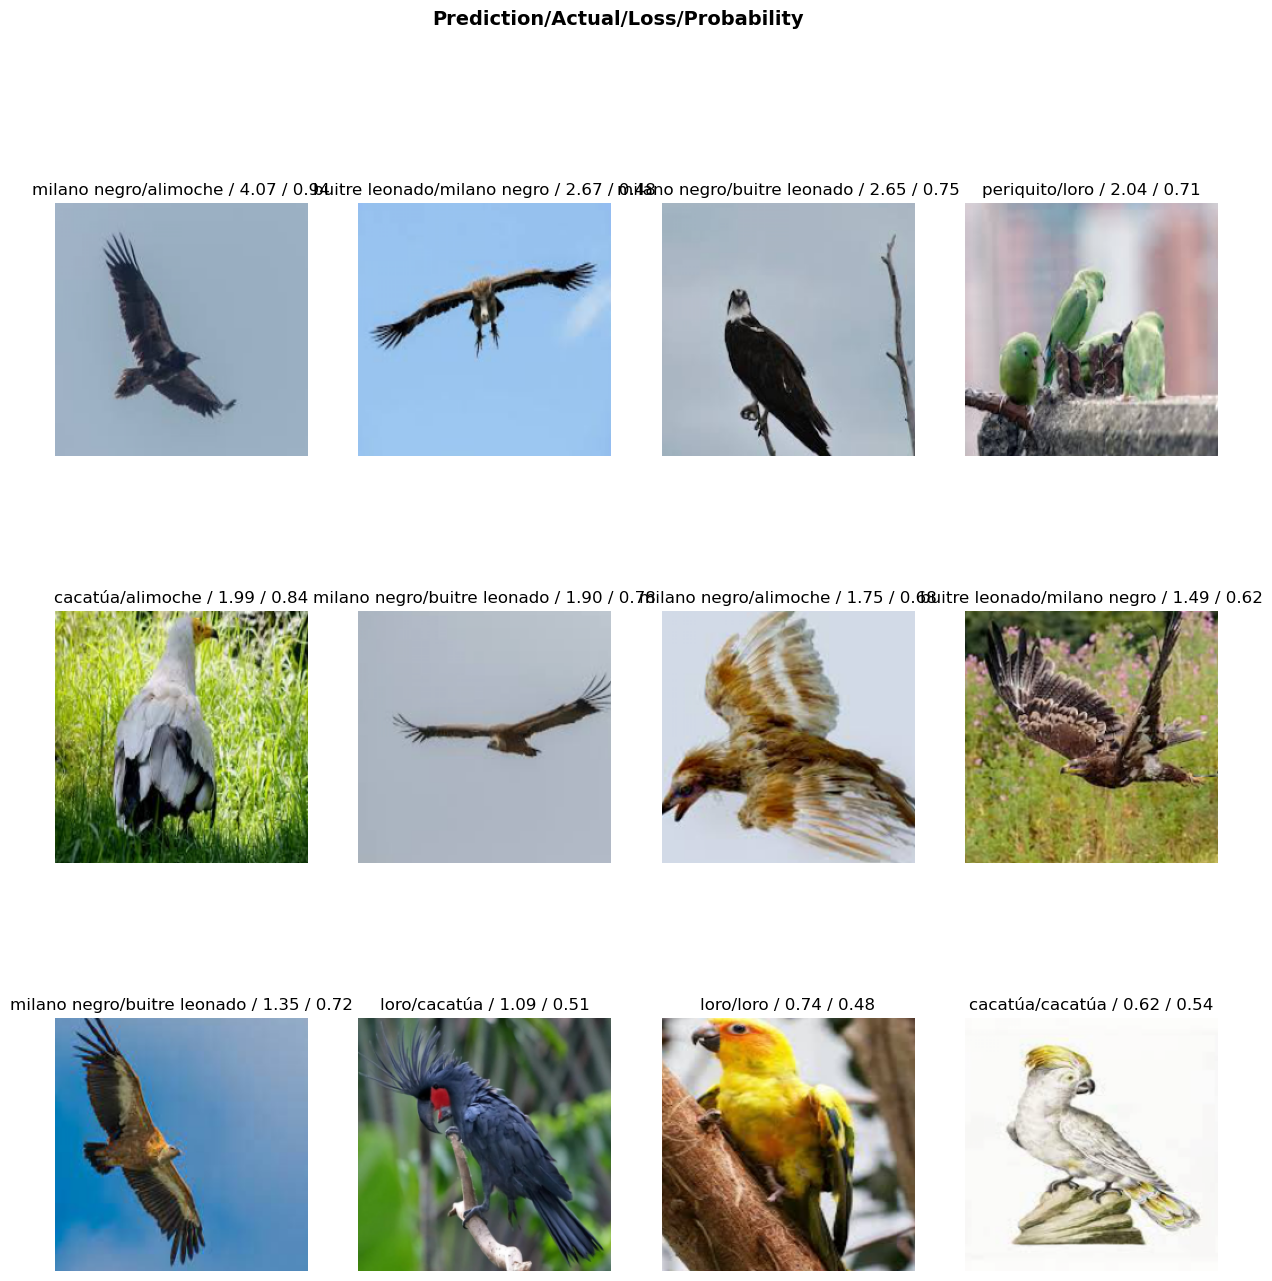

In [28]:
interpTest.plot_top_losses(12, figsize=(15,15))

### Fine tuning

In [26]:
learn.load('trainmodel')

cbs_test = [EarlyStoppingCallback(monitor='valid_loss', patience=3), ReduceLROnPlateau(monitor='valid_loss', min_delta=0.05, factor=7.5), SaveModelCallback(monitor='valid_loss', fname='bestmodel')]

learn.fine_tune(10, cbs=cbs_test)

epoch,train_loss,valid_loss,accuracy,time
0,0.570766,0.280880,0.915094,01:29


Better model found at epoch 0 with valid_loss value: 0.2808797359466553.


epoch,train_loss,valid_loss,accuracy,time
0,0.525178,0.282170,0.924528,01:51
1,0.411254,0.248094,0.915094,01:51
2,0.347964,0.254963,0.933962,01:51
3,0.311151,0.282073,0.905660,01:51
4,0.270180,0.373946,0.896226,01:51


Better model found at epoch 0 with valid_loss value: 0.2821703851222992.
Better model found at epoch 1 with valid_loss value: 0.2480938732624054.
Epoch 1: reducing lr to 9.948484887789789e-05
Epoch 2: reducing lr to 0.00013273764413621942
Epoch 3: reducing lr to 0.00012846116636853667
Epoch 4: reducing lr to 0.00011148694561507197
No improvement since epoch 1: early stopping


### Evaluación tras el fine tuning

Evaluación del modelo sobre el conjunto de test tras el fine tuning (ajuste de los pesos de todas las capas)

0.20954863727092743 0.925000011920929


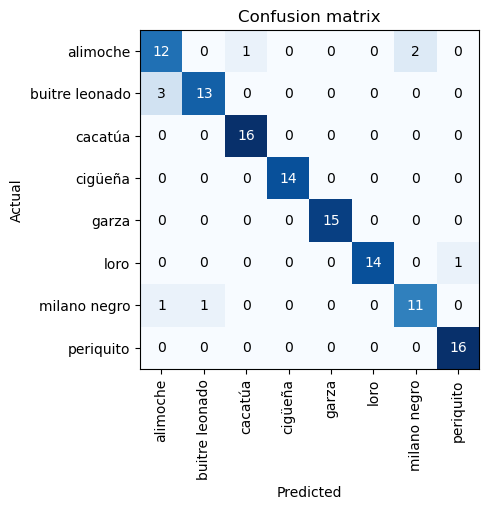

In [30]:
learn.load('bestmodel')
test_loss, test_accuracy = learn.validate(dl=test_dl)
interpTest = ClassificationInterpretation.from_learner(learn, dl=test_dl)
interpTest.plot_confusion_matrix(figsize=(5,5))
print(test_loss, test_accuracy)

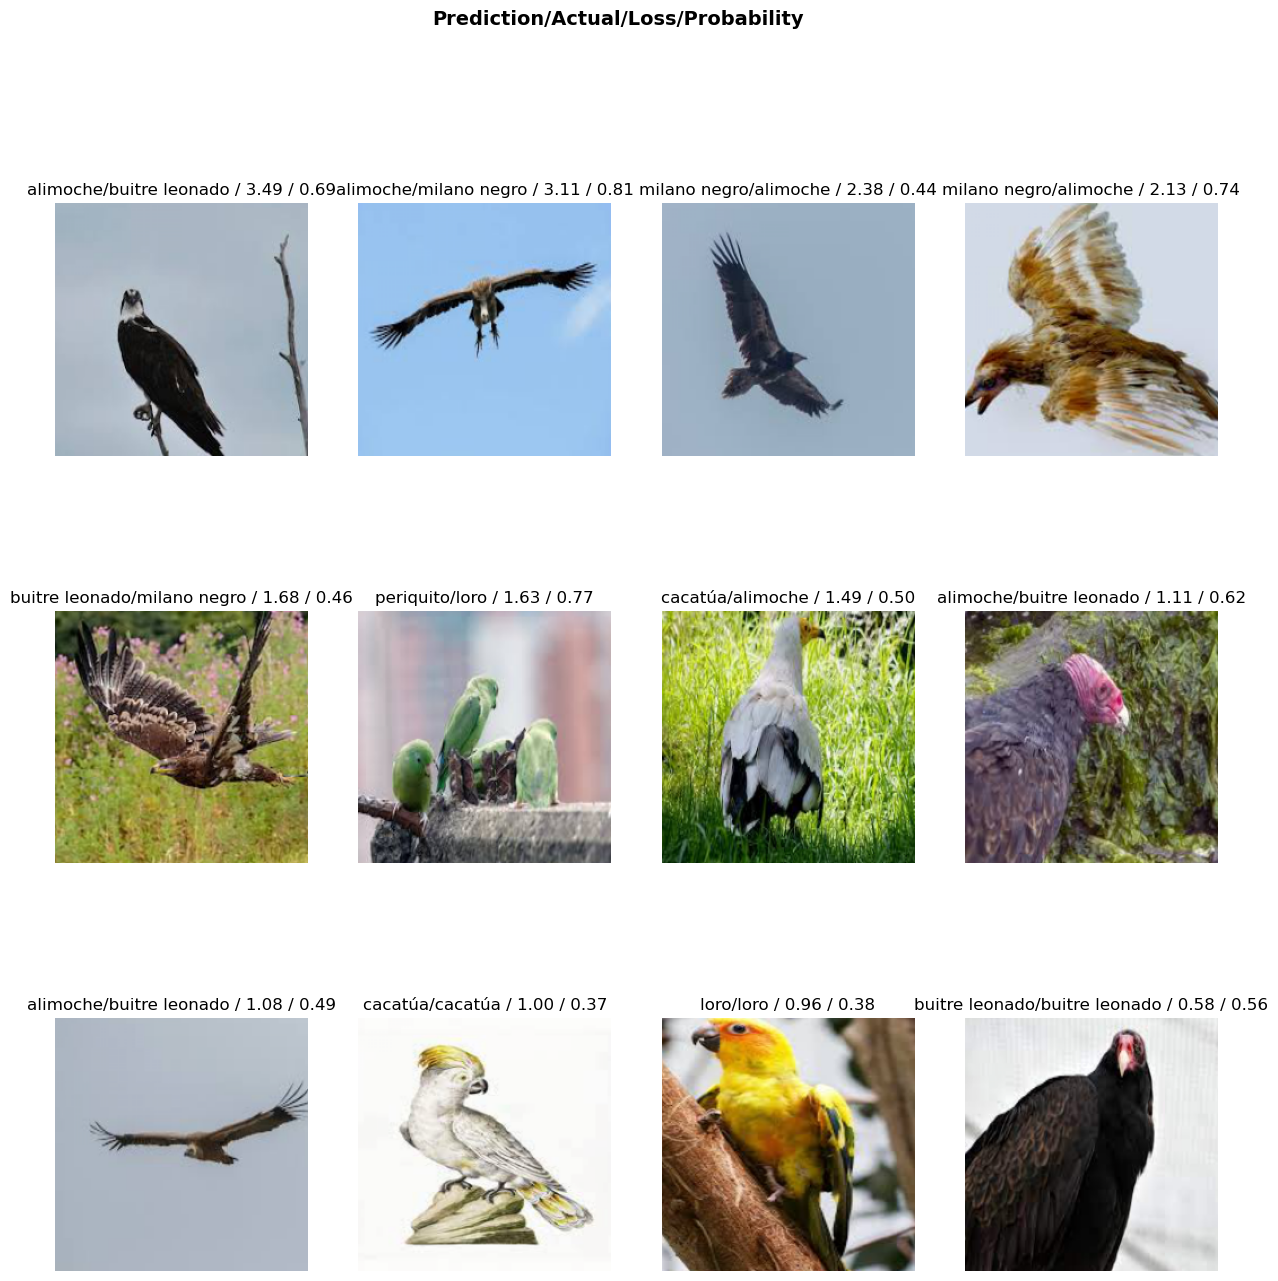

In [31]:
interpTest.plot_top_losses(12, figsize=(15,15))

## Guardamos el modelo obtenido tras el fine tuning

In [32]:
learn.load('bestmodel')
learn.export()

0.20954863727092743 0.925000011920929


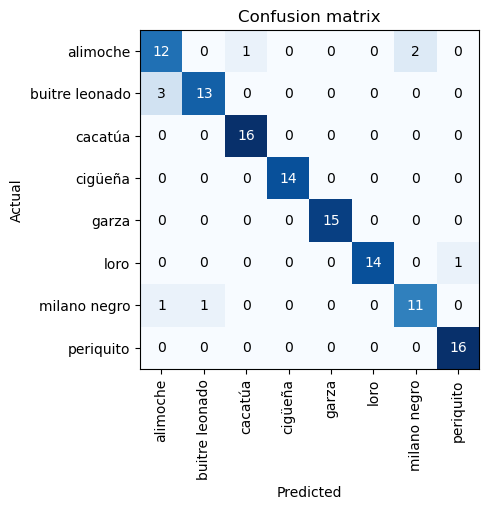

In [34]:
learn = load_learner(Path().cwd()/'export.pkl')
test_loss, test_accuracy = learn.validate(dl=test_dl)
interpTest = ClassificationInterpretation.from_learner(learn, dl=test_dl)
interpTest.plot_confusion_matrix(figsize=(5,5))
print(test_loss, test_accuracy)